INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa88yfnvk/w9geqa4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa88yfnvk/sn52hq9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/workspaces/Forecasts/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55212', 'data', 'file=/tmp/tmpa88yfnvk/w9geqa4y.json', 'init=/tmp/tmpa88yfnvk/sn52hq9t.json', 'output', 'file=/tmp/tmpa88yfnvk/prophet_modelzdtybylz/prophet_model-20250319045649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:56:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:56:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/workspaces/Forecasts/

El modelo se guardó correctamente en: ../models/prophet_model.pkl
El modelo se cargó correctamente: {'model': <prophet.forecaster.Prophet object at 0x7008fe1ca090>, 'algorithm_name': 'Prophet', 'author': 'Enrique', 'dataset_info': {'num_records': 38, 'columns': ['ds', 'y']}, 'prediction_info': {'forecast_horizon': 3, 'past_window': 6}, 'metrics': 'No aplica en Prophet', 'notes': 'Modelo para pronóstico de llamadas'}


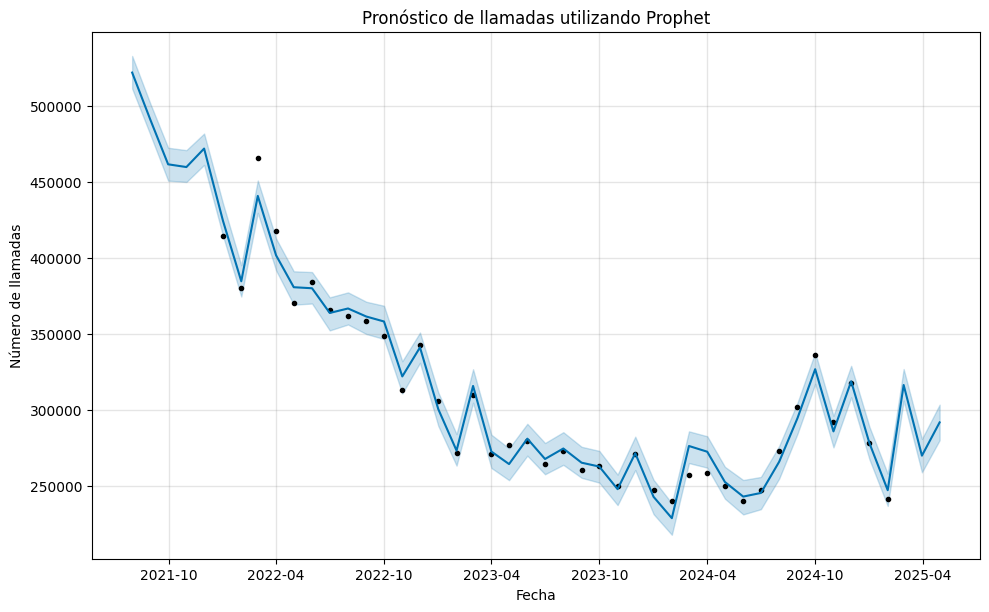

           ds           yhat     yhat_lower     yhat_upper
37 2024-09-01  294505.866467  284192.906825  304632.058401
38 2024-10-01  326740.896663  317064.126255  337753.174359
39 2024-11-01  285790.146353  275244.712845  295995.041423
40 2024-12-01  318746.141120  308245.065858  328965.322866
41 2025-01-01  278030.752678  267369.236268  288813.862407
42 2025-02-01  247055.773513  236667.399044  257898.115311
43 2025-02-28  316341.194240  306111.371594  326858.103188
44 2025-03-31  269810.039310  258829.219349  280820.229464
45 2025-04-30  291712.024594  279998.039464  303387.715443


In [1]:

import os
import pickle
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import logging

# Configurar el logger
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

# Cargar el dataset
df = pd.read_csv('../history/HISTORY.csv')
df['Fechas'] = pd.to_datetime(df['Fechas'], format='%m/%d/%Y')
df.rename(columns={'Fechas': 'ds', 'Llamadas': 'y'}, inplace=True)

# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(df)

# Crear un DataFrame para las fechas futuras (3 meses futuros)
future = model.make_future_dataframe(periods=3, freq='M')

# Crear un DataFrame para las fechas pasadas (3 meses pasados)
past = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min() - pd.DateOffset(months=6), 
                                         end=df['ds'].min() - pd.DateOffset(months=1), 
                                         freq='M')})

# Combinar ambos DataFrames
combined = pd.concat([past, future], ignore_index=True)

# Realizar la predicción
forecast = model.predict(combined)

# Crear un diccionario con los detalles del modelo Prophet
model_dict = {
    'model': model,
    'algorithm_name': 'Prophet',
    'author': 'Enrique',
    'dataset_info': {
        'num_records': len(df),
        'columns': list(df.columns)
    },
    'prediction_info': {
        'forecast_horizon': 3,  # meses futuros
        'past_window': 6        # meses pasados
    },
    'metrics': 'No aplica en Prophet',  # Prophet no calcula métricas como accuracy directamente
    'notes': 'Modelo para pronóstico de llamadas'
}

# Crear la ruta del archivo
output_dir = '../models'
output_file = 'prophet_model.pkl'

# Guardar el modelo en un archivo pickle
try:
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, output_file), 'wb') as file:
        pickle.dump(model_dict, file)
        print("El modelo se guardó correctamente en:", os.path.join(output_dir, output_file))
except Exception as e:
    logger.error(f"Ha ocurrido un error al guardar el modelo: {e}")

# Cargar el modelo desde el archivo pickle (para verificar)
try:
    with open(os.path.join(output_dir, output_file), 'rb') as file:
        loaded_model = pickle.load(file)
        print("El modelo se cargó correctamente:", loaded_model)
except Exception as e:
    logger.error(f"Ha ocurrido un error al cargar el modelo: {e}")

# Graficar los resultados
fig1 = model.plot(forecast)
plt.title('Pronóstico de llamadas utilizando Prophet')
plt.xlabel('Fecha')
plt.ylabel('Número de llamadas')
plt.show()

# Mostrar el pronóstico final (últimos 9 registros)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))
